In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.set_cmap('rainbow')
import pyemma
from tqdm import tqdm_notebook

<Figure size 432x288 with 0 Axes>

/home/psapir/anaconda3/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.6, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)


In [38]:
states = np.arange(0, 2, 1).astype(int)
p12 = 0.01
p21 = 0.03
p11 = 1-p12
p22 = 1-p21
T_matrix = np.array([[p11, p12],
                     [p21, p22]])
for row in T_matrix:
    print(sum(row))

1.0
1.0


In [39]:
num_steps = 10000

In [40]:
trajectory = np.zeros(num_steps).astype(int)
trajectory[0] = 0
for i, s in tqdm_notebook(enumerate(trajectory[:-1])):
    trajectory[i+1] = np.random.choice(states, p=T_matrix[s])

t12=96.97, t21=37.37
t12/t21=2.59, p21/p12=3.00
k12=0.01
k21=0.03
k=0.96
its=26.47


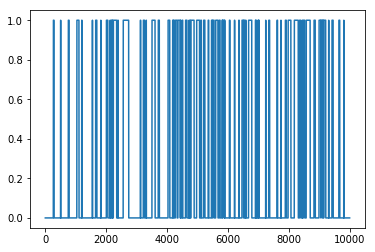

In [41]:
plt.plot(trajectory)

trans12_indeces = np.array([i for i, e in enumerate(trajectory[:-1]) if trajectory[i]==0 and trajectory[i+1]==1])
trans21_indeces = np.array([i for i, e in enumerate(trajectory[:-1]) if trajectory[i]==1 and trajectory[i+1]==0])
trans21_indeces = np.insert(trans21_indeces, 0, 0)

if trans12_indeces.shape[0] < trans21_indeces.shape[0]:
    trans12_indeces = np.append(trans12_indeces, 0)
    
trans12 = trans12_indeces - trans21_indeces
trans12 = trans12[trans12 >= 0]
trans21 = (trans21_indeces - np.insert(trans12_indeces, 0, 0)[:-1])[1:]
trans21 = trans21[trans21 >= 0]

#print(trans12)
#print(trans21)

t12 = np.mean(trans12)
t21 = np.mean(trans21)

print('t12={:0.2f}, t21={:0.2f}'.format(t12, t21))
print('t12/t21={:0.2f}, p21/p12={:0.2f}'.format(t12/t21, p21/p12))

k12 = 1/t12
k21 = 1/t21
print('k12={:0.2f}'.format(k12))
print('k21={:0.2f}'.format(k21))

k_mat = np.array([[1-k12, k12],
                  [k21, 1-k21]])
eig_k = np.linalg.eigvals(k_mat)
k = np.sort(eig_k)[0]
print('k={:0.2f}'.format(k))
its_theory = -1/np.log(np.abs(k))
print('its={:0.2f}'.format(its_theory))

Mean of first ITS: 26.530457
Confidence interval: [23.455953, 30.912845]
fraction of states used = 1.000000
fraction of counts used = 1.000000
sum of weights = 1.000000


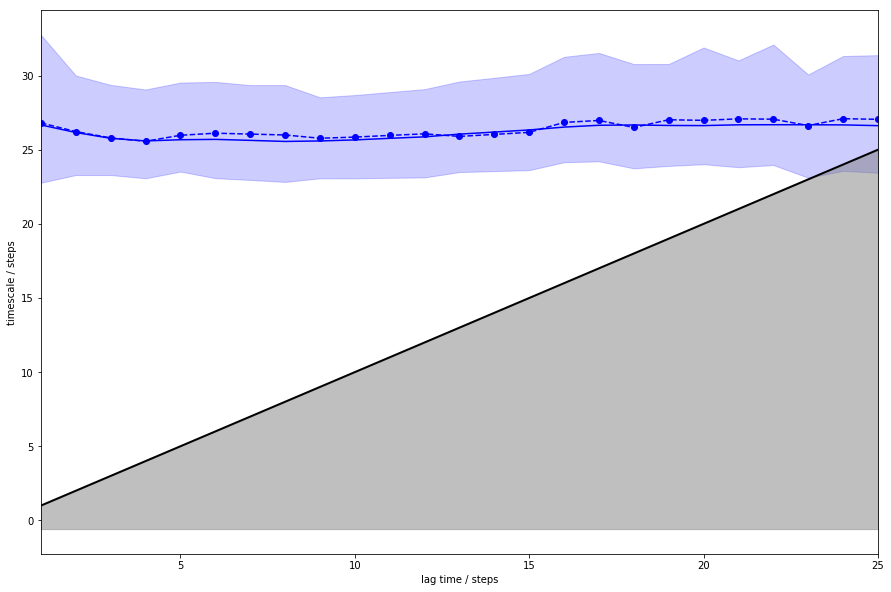

In [42]:
its_sim = pyemma.msm.its(trajectory, lags=np.linspace(1, 25, 25).astype(int), nits=1, errors='bayes')
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
pyemma.plots.plot_implied_timescales(its_sim, ylog=False, ax=axes)

LAG = 15
bayesian_msm = pyemma.msm.bayesian_markov_model(trajectory, lag=LAG, conf=0.95)
sample_mean = bayesian_msm.sample_mean('timescales', k=1)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=1)

print('Mean of first ITS: {:f}'.format(sample_mean[0]))
print('Confidence interval: [{:f}, {:f}]'.format(sample_conf_l[0], sample_conf_r[0]))
msm = pyemma.msm.estimate_markov_model(trajectory, lag=LAG)

print('fraction of states used = {:f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(msm.active_count_fraction))
print('sum of weights = {:f}'.format(msm.pi.sum()))

In [14]:
msm = pyemma.msm.bayesian_markov_model(trajectory, 1, reversible=False,
                                       nsamples=10000, conf=0.95, count_mode='effective',
                                       mincount_connectivity=0, show_progress=True)

<BarContainer object of 149 artists>

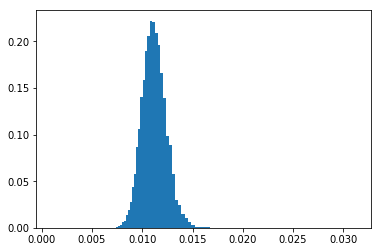

In [15]:
xmin, xmax = -3, -1.5
bins = np.logspace(xmin, xmax, 150)
sample_rates = np.array(msm.sample_f('P'))[:,0,1]
sample_rates_hist, bin_edges = np.histogram(sample_rates, bins=bins, normed=False)

plt.bar(bins[:-1], sample_rates_hist*(bins[1:]-bins[:-1]), bins[1:]-bins[:-1])